In [1]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [3]:
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

In [26]:
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shinto',
    'Pagan'
]

In [105]:
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

## Utility methods

In [27]:
def text_to_vector(embeddings,text):
    tokens = text.split()
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        return np.mean(embeddings[words],axis = 0)
    return None

In [28]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_prob(vector)
        return prob
    else: return 0;

In [29]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [137]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
        words.append(word)
    return zip(words,toxicities)

In [9]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [10]:
def generate_train_test_set(model,targets,sentences,dim=300):
    vectors = np.zeros((len(sentences),dim))
    labels = np.zeros((len(sentences)))
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)>0:
            vectors[count,:] = np.mean(model[words],axis = 0)
            labels[count] = targets[i] 
            count+=1
    print count, " sentences in embeddings, ", len(sentences) - count, " sentences not in embeddings"
    return train_test_split(vectors, labels, test_size=0.1, random_state=0)

In [69]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=5000,val=None,X_tils =[],lamb=.1,reg_coeff=[]):
        self.lr = lr
        self.num_iter = num_iter
        self.val = val
        self.X_tils = X_tils
        self.lamb = lamb
        self.reg_coeff = reg_coeff
   
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def calculate_fairness_reg_grad(self,theta):
        fair_reg_sum = 0
        for i,X_til in enumerate(self.X_tils):
            l = np.shape(X_til)[0]
            z_til = np.dot(X_til, theta)
            h_til = self.__sigmoid(z_til)
            T = np.sum(h_til)
            fair_reg_sum+=self.reg_coeff[i]*(np.sum(X_til.T*h_til*(1-h_til)*(np.log(l*h_til)+1),axis=1))
        return fair_reg_sum
    
    def fit(self, X, y):
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        RNSB = []
        loss = []
        validation_scores = []
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            r = self.calculate_fairness_reg_grad(self.theta)
            grad_loss = np.dot(X.T, (h - y)) / y.size
            #logistic loss + L2 regularization + sum(fair_reg)
            if(i % 1000 == 0):
                print np.sum(np.abs(grad_loss)), np.sum(np.abs(2*self.lamb*self.theta)), np.sum(np.abs(r))
            gradient = grad_loss + 2*self.lamb*self.theta+ r
            self.theta -= self.lr * gradient
            RNSB.append(self.validation_fairness())
            loss.append(self.__loss(h, y))
            validation_scores.append(self.validation(self.val[0],self.val[1]))
            if(i % 1000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print 'loss: ' ,self.__loss(h, y)
                if self.val:
                    print 'validation MAp: ', self.validation(self.val[0],self.val[1])
                if len(self.X_tils)>0:
                    print 'RNSB: ', self.validation_fairness()
        return (RNSB,loss,validation_scores)    
    
    def predict_prob(self, X):
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict_proba(self, X):
        return [1-self.__sigmoid(np.dot(X, self.theta)),self.__sigmoid(np.dot(X, self.theta))]
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def validation(self,X,Y):
        return np.mean(self.predict(X,.5)==Y)
    
    def validation_fairness(self):
        vals = []
        for Xtil in self.X_tils:
            probs = self.predict_prob(Xtil)
            probs = probs/np.sum(probs)
            uniform = np.ones(len(probs))*1./len(probs)
            vals.append((probs * np.log(probs/uniform)).sum())
        return vals
    def print_val_fairness(self):
        vals = []
        for Xtil in self.X_tils:
            probs = self.predict_prob(Xtil)
            probs = probs/np.sum(probs)
            print probs
            uniform = np.ones(len(probs))*1./len(probs)
            vals.append((probs * np.log(probs/uniform)).sum())
        print vals

## Load Datasets

In [13]:
#GLOVE
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'data/glove.6B/glove.6B.300d.txt'
word2vec_output_file = 'data/glove.6B/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

#Word2vec
# embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

#universal sentence encoder
# import tensorflow as tf
# import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# # Import the Universal Sentence Encoder's TF Hub module
# embed = hub.Module(module_url)

In [14]:
#kaggle

#df = pd.read_csv("data/kaggle_toxicity/train.csv")

#word sentiment

pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

#imbd

# import numpy
# from keras.datasets import imdb
# from matplotlib import pyplot
# # load the dataset
# (X_train, y_train), (X_test, y_test) = imdb.load_data()
# X = numpy.concatenate((X_train, X_test), axis=0)
# y = numpy.concatenate((y_train, y_test), axis=0)

## Initialize word sentiment dataset or toxicity dataset (wiki)

In [15]:
#sentiment word dataset from positve/negative reviews
#'''
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
#'''
#toxicity tweet dataset
#''''''
# toxic_sentences = df[df["toxic"]==1]["comment_text"]
# num_toxic_samples = len(toxic_sentences)
# non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
# sentences = pd.concat([toxic_sentences, non_toxic_sentences])
# targets  = np.zeros(num_toxic_samples*2)
# targets[0:num_toxic_samples] = 1
# train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences)
# sentences = map(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x.lower()),list(sentences))
# # message_embeddings = None
# # with tf.Session() as session:
# #     session.run([tf.global_variables_initializer(), tf.tables_initializer()])
# #     message_embeddings = session.run(embed(sentences))
# #     print np.shape(message_embeddings)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec = TfidfVectorizer(ngram_range=(1,2),
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1)
# trn_term_doc = vec.fit_transform(sentences)

# train_vectors, test_vectors, train_targets, test_targets = train_test_split(trn_term_doc.todense(), targets,test_size=0.1, random_state=0)

#'''


    
# import re, string
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# def tokenize(s): return re_tok.sub(r' \1 ', s).split()
# n = train.shape[0]
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# trn_term_doc = vec.fit_transform(train[COMMENT])
# test_term_doc = vec.transform(test[COMMENT])
#imbd movie ratings?????

## Create fair regression terms

In [115]:
N = np.zeros((len(nationalities),300))
for i,j in enumerate(nationalities):
    N[i,:] = embeddings[j.lower()]
R = np.zeros((len(religions),300))
for i,j in enumerate(religions):
    R[i,:] = embeddings[j.lower()]
G = np.zeros((len(gender),300))
for i,j in enumerate(gender):
    G[i,:] = embeddings[j.lower()]
regularizers = [N,R,G]

## train LR

In [173]:
lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[0,0,0],lamb=0.01,num_iter=8000)
(RNSB,loss,validation_scores) = lr.fit(train_vectors,train_targets)
print "----------------------------------------------"
lr_debias = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers,reg_coeff=[.1,.1,.1],lamb=0.01,num_iter=8000)
(RNSB_debias,loss_debias,validation_scores_debias) = lr_debias.fit(train_vectors,train_targets)

6.680747659247539 0.0 0.0
loss:  0.6907998854945373
validation MAp:  0.7756410256410257
RNSB:  [1.2060399657140488e-07, 2.1678092289534023e-06, 3.749548287541285e-07]
1.4826837440892877 0.4480731470360366 0.0
loss:  0.31391387212695326
validation MAp:  0.8958333333333334
RNSB:  [0.040601889968077065, 0.06953242102128158, 0.02507413445656658]
1.028518680838061 0.5814511478138917 0.0
loss:  0.27069666727988284
validation MAp:  0.9086538461538461
RNSB:  [0.06780803268726245, 0.09480267170208623, 0.04168673706673111]
0.8714597330907601 0.6442769184157627 0.0
loss:  0.2551738471135593
validation MAp:  0.9102564102564102
RNSB:  [0.08156488798015986, 0.1074973792398739, 0.05052535882748414]
0.8012856589533417 0.6774424682266981 0.0
loss:  0.24797432057125116
validation MAp:  0.9102564102564102
RNSB:  [0.08876831239584315, 0.11435330473605103, 0.055174141051051145]
0.7663071063074398 0.6958156149464908 0.0
loss:  0.24422595041086942
validation MAp:  0.9118589743589743
RNSB:  [0.092683947249133

## plot toxicity histogram for identity terms

In [92]:
lr_debias.validation_fairness(),lr.validation_fairness()


([0.00852651620535181], [0.04410181689344861])

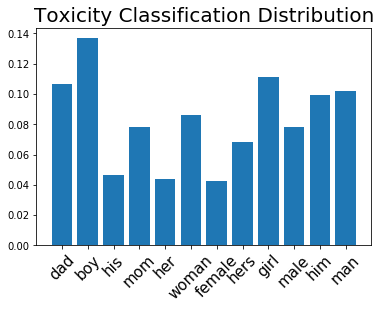

In [118]:
identity_toxicity = dict(identity_toxicity_table(gender,embeddings,lr))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

In [133]:
terms= []
for i in nationalities:
    terms.append("i love " + i + " food")

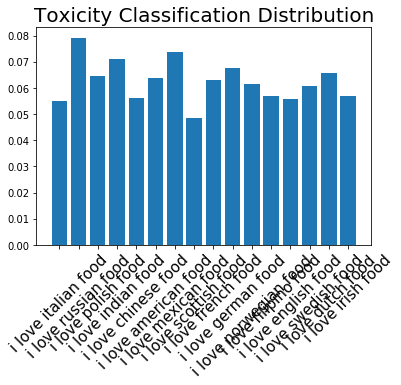

In [140]:
identity_toxicity = dict(identity_toxicity_table(terms,embeddings,lr))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

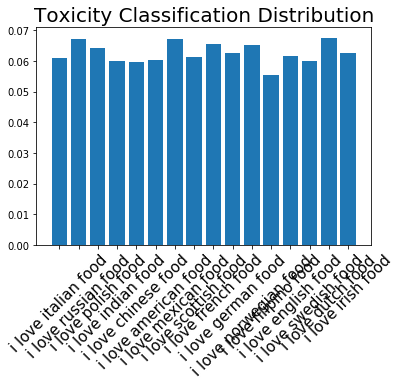

In [139]:
identity_toxicity = dict(identity_toxicity_table(terms,embeddings,lr_debias))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

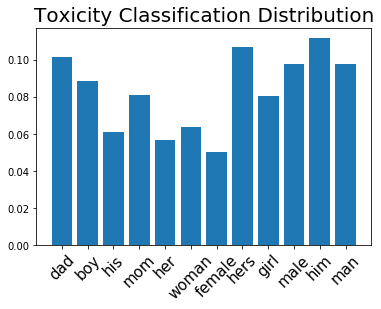

In [119]:
identity_toxicity = dict(identity_toxicity_table(gender,embeddings,lr_debias))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

## Plot training curves

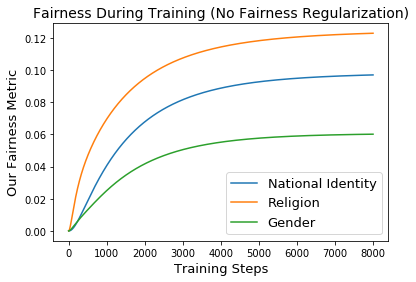

In [157]:
plt.figure()
plt.plot(zip(*RNSB)[0],label="National Identity")
plt.plot(zip(*RNSB)[1],label="Religion")
plt.plot(zip(*RNSB)[2],label="Gender")

#maybe also do analysi with no regulaization


plt.title("Fairness During Training (No Fairness Regularization)",fontsize=14)
plt.xlabel("Training Steps",fontsize=13)
plt.ylabel("Our Fairness Metric",fontsize=13)

plt.legend(fontsize=13)

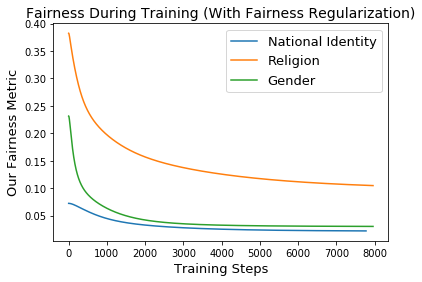

In [156]:
plt.figure()
plt.plot(zip(*RNSB_debias)[0][np.argmax(zip(*RNSB_debias)[0]):],label="National Identity")
plt.plot(zip(*RNSB_debias)[1][np.argmax(zip(*RNSB_debias)[1]):],label="Religion")
plt.plot(zip(*RNSB_debias)[2][np.argmax(zip(*RNSB_debias)[2]):],label="Gender")


plt.title("Fairness During Training (With Fairness Regularization)",fontsize=14)
plt.xlabel("Training Steps",fontsize=13)
plt.ylabel("Our Fairness Metric",fontsize=13)

plt.legend(fontsize=13)

## test toxicity on gender equalized vs non equalized

In [160]:
text_to_toxicity(lr,embeddings,'fuck'),text_to_toxicity(lr_debias,embeddings,'fuck')

(0.848954512533737, 0.5655761868686644)

In [82]:
text_to_toxicity(lr,embeddings,'US'),text_to_toxicity(lr,embeddings,'mexico')

(0.2572226555117645, 0.3838664724403921)

In [84]:
text_to_toxicity(lr_debias,embeddings,'US'),text_to_toxicity(lr_debias,embeddings,'mexico')

(0.19329804705651543, 0.15516065160752815)

In [85]:
text_to_toxicity(lr,embeddings,'i am american'),text_to_toxicity(lr,embeddings,'i am mexican')

(0.23485256147083103, 0.28319029692395403)

In [86]:
text_to_toxicity(lr_debias,embeddings,'i am american'),text_to_toxicity(lr_debias,embeddings,"i am mexican")

(0.10264468698576451, 0.1182315797185911)

In [87]:
text_to_toxicity(lr,embeddings,'catholic'),text_to_toxicity(lr,embeddings,'jewish')

(0.17000008695876936, 0.33463219049071596)

In [88]:
text_to_toxicity(lr_debias,embeddings,'catholic'),text_to_toxicity(lr_debias,embeddings,'jewish')

(0.016593033039892714, 0.008235259562343234)

In [97]:
text_to_toxicity(lr,embeddings,'male'),text_to_toxicity(lr,embeddings,'female')

(0.41555138890880217, 0.22633257928494263)

In [96]:
text_to_toxicity(lr_debias,embeddings,'male'),text_to_toxicity(lr_debias,embeddings,'female')

(0.2115246268520528, 0.16272232321368868)

In [112]:
text_to_toxicity(lr,embeddings,'boy'),text_to_toxicity(lr,embeddings,'girl')

(0.7245828725912505, 0.5903031976167027)

In [113]:
text_to_toxicity(lr_debias,embeddings,'boy'),text_to_toxicity(lr_debias,embeddings,'girl')

(0.03489446278584045, 0.03163119670096145)

In [114]:
text_to_toxicity(lr_debias,embeddings,'dude'),text_to_toxicity(lr_debias,embeddings,'gal')

(0.34209153462660347, 0.43033493025112585)

## create identity keyword toxicity histograms

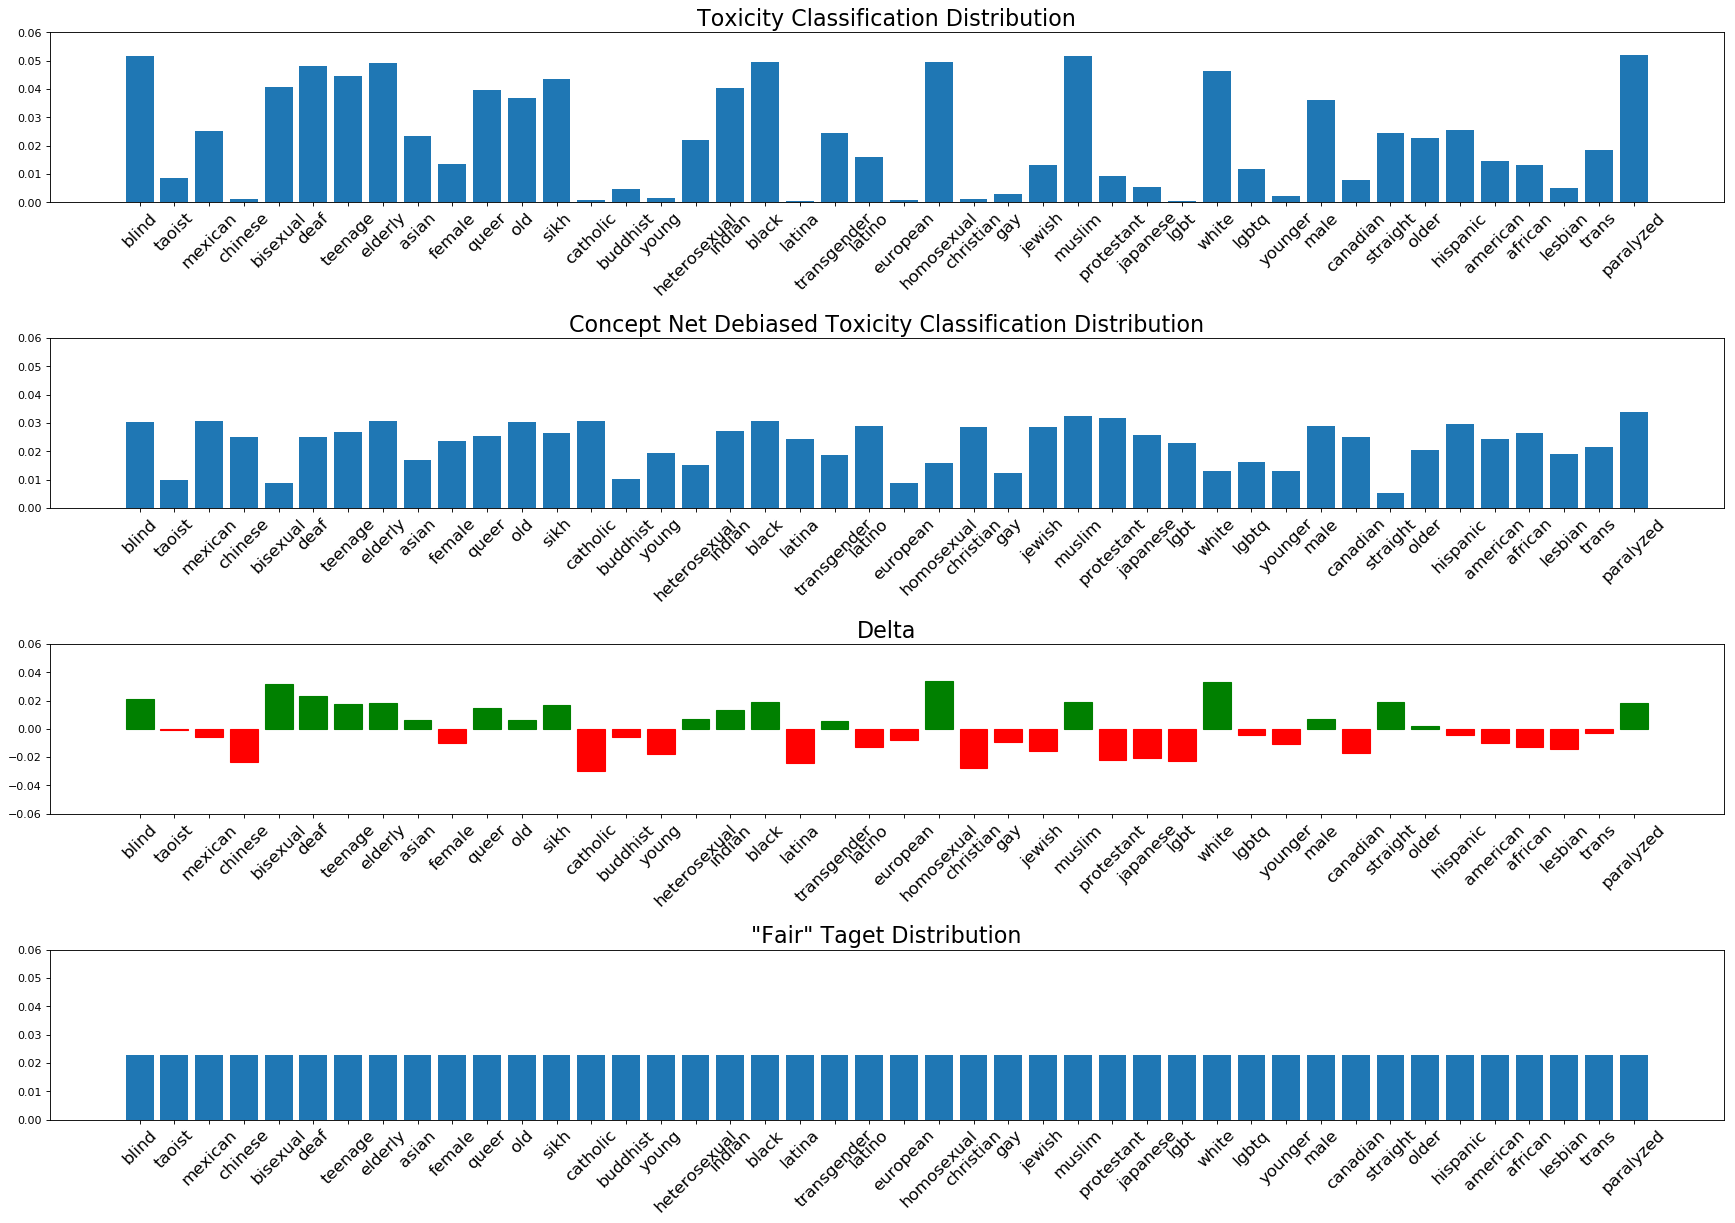

kl divergence from uniform dist for concept net: 0.06231244525227526
kl divergence from uniform dist for google news: 0.3595368787300598


In [15]:
identity_toxicity_debias = dict(identity_toxicity_table(identities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(identities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

## model comparison with different methods

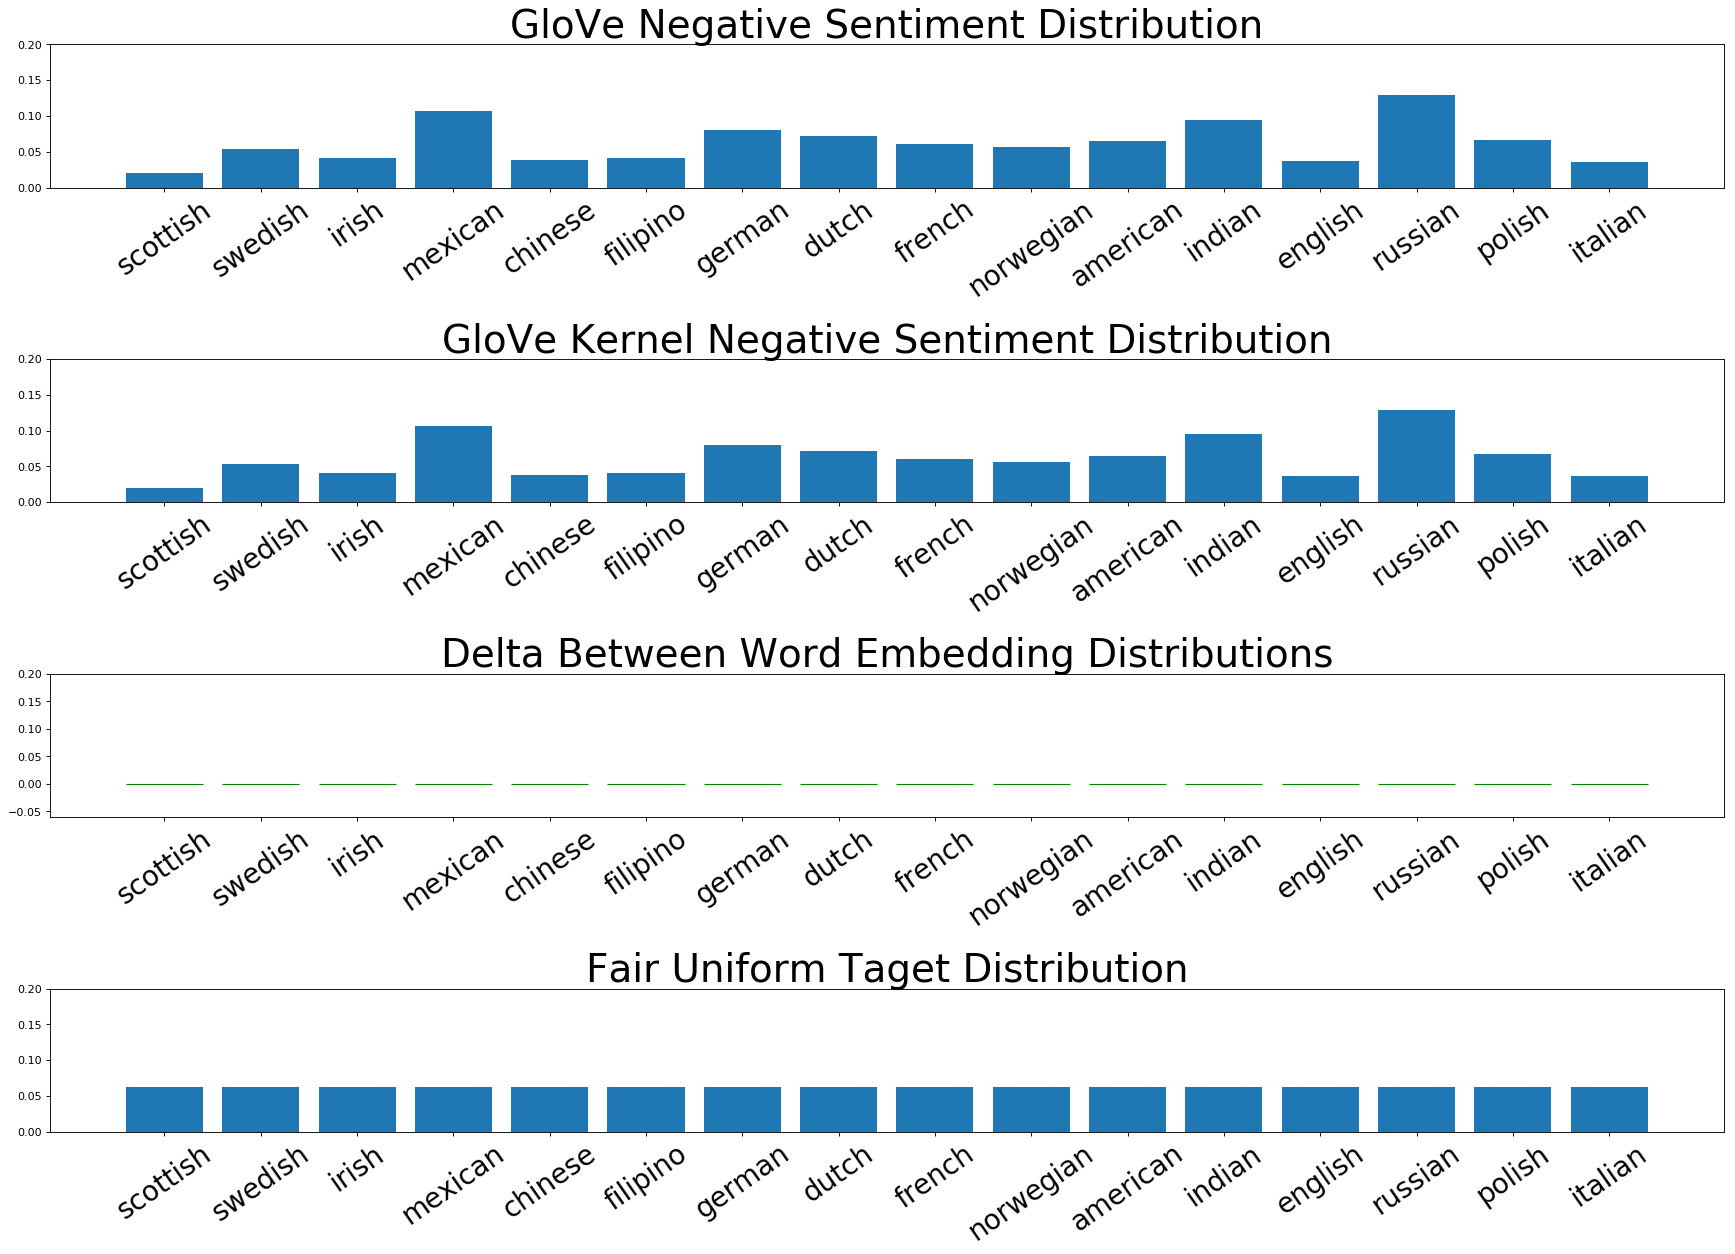

kl divergence from uniform dist for concept net: 0.09697369206899908
kl divergence from uniform dist for google news: 0.09697369206899908


In [162]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,lr))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("GloVe Kernel Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Word Embedding Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Taget Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

kl divergence from uniform dist for concept net: 0.09697369206899908
kl divergence from uniform dist for google news: 0.09697369206899908


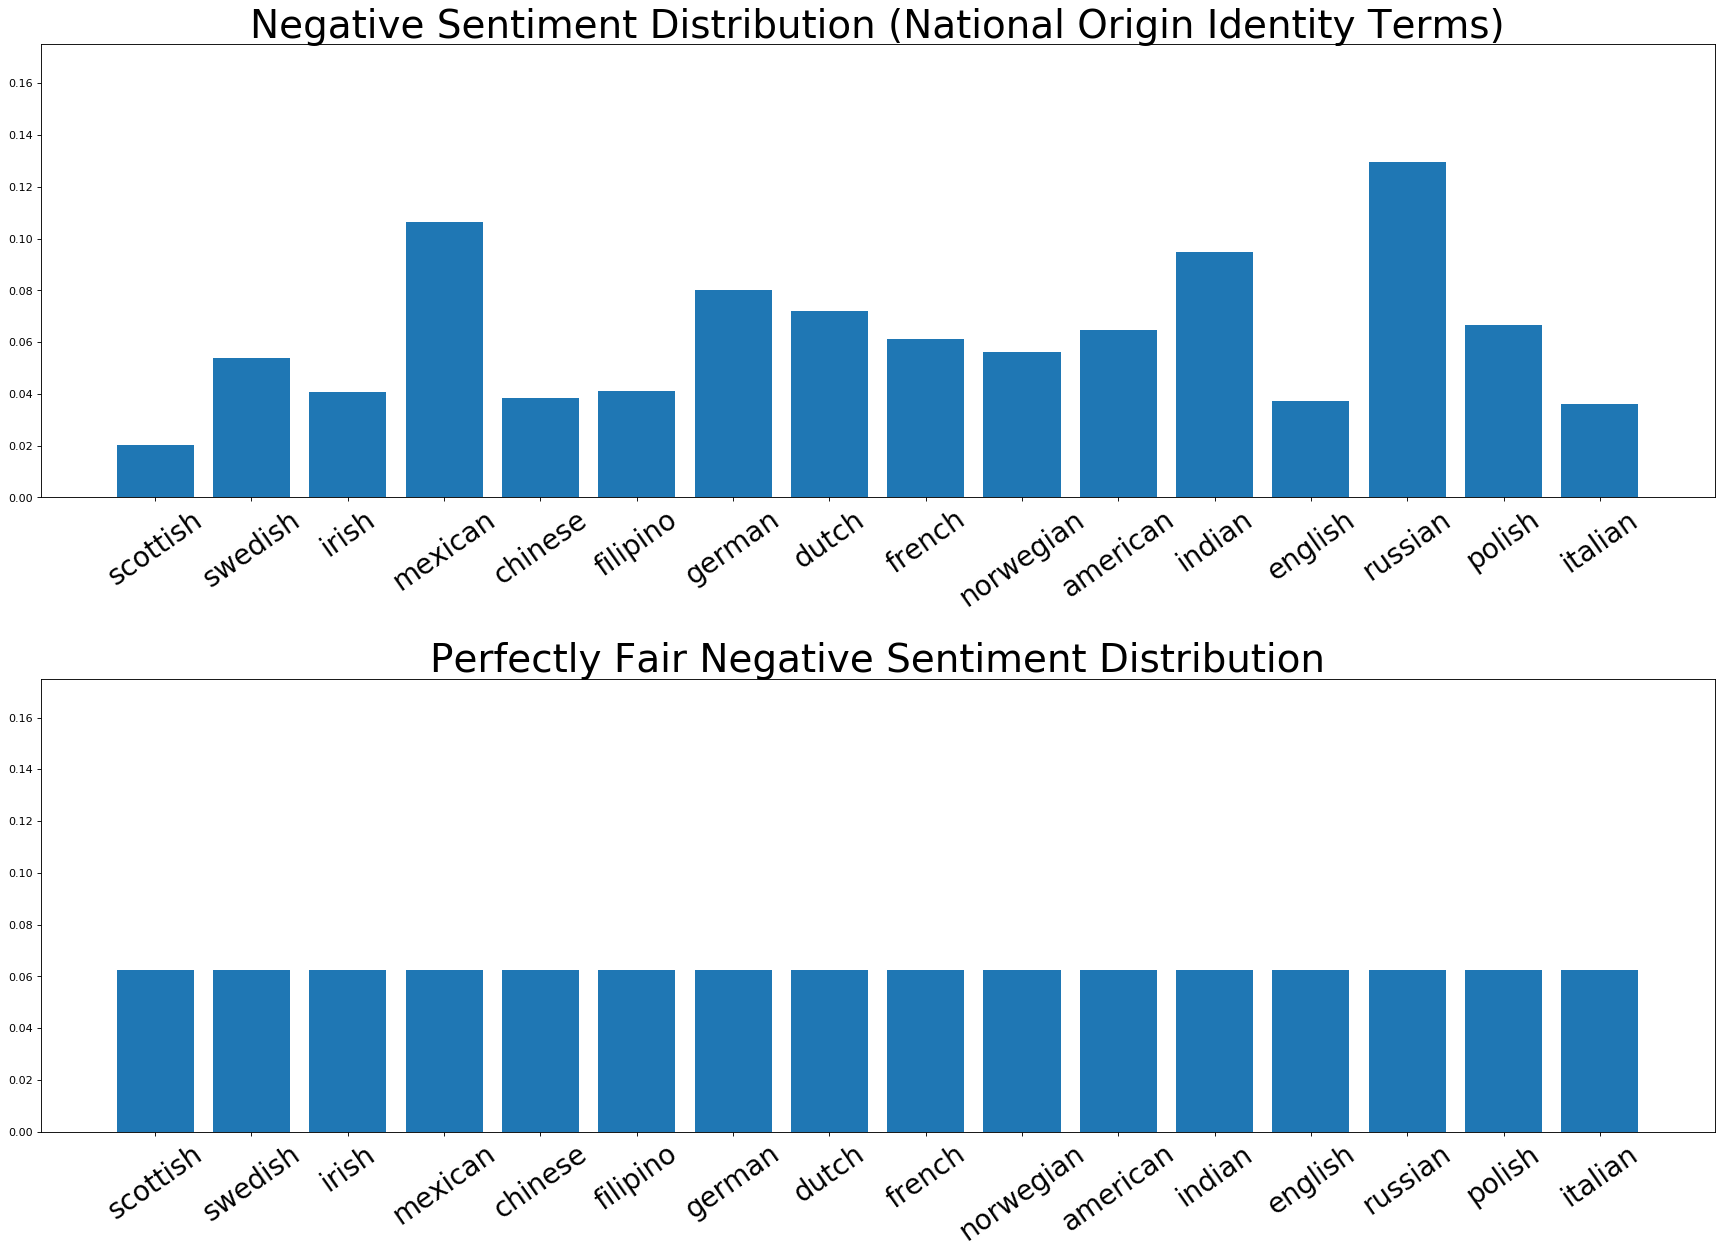

In [172]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,lr))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.4)
f.add_subplot(211)
plt.title("Negative Sentiment Distribution (National Origin Identity Terms)",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.175,bottom=0)
f.add_subplot(212)
plt.title("Perfectly Fair Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,1./len(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.175,bottom=0)


debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

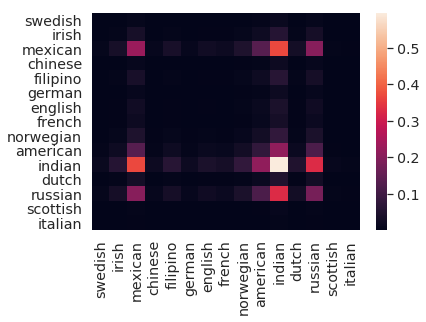

In [103]:
from pandas import DataFrame
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline
A = np.outer(identity_toxicity[1],identity_toxicity[1])

df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity[0])

sns.heatmap(df, annot=False)

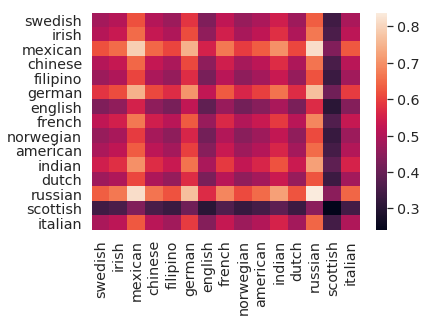

In [104]:
A = np.outer(identity_toxicity_debias[1],identity_toxicity_debias[1])

df = DataFrame(A, index=identity_toxicity_debias[0], columns=identity_toxicity_debias[0])

sns.heatmap(df, annot=False)